In [9]:
from data.loader import get_dataset
from models.u2net import U2NET, bce_loss

import pathlib, os
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

In [10]:
TRAIN_PATH = "./datasets/DUTS/DUTS-TR/"
TEST_PATH = "./datasets/DUTS/DUTS-TE/"

IMAGE_SHAPE = (320, 320, 3)
MASK_SHAPE = (320, 320, 1)

# Training
BATCH_SIZE = 8
EPOCHS = 300
LEARNING_RATE = 0.001

In [11]:
def display(display_list):
  plt.figure(figsize=(8, 8))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [12]:
train_dataset = get_dataset(TRAIN_PATH, IMAGE_SHAPE, MASK_SHAPE, batch=BATCH_SIZE, needAugmentation=True)
test_dataset = get_dataset(TEST_PATH, IMAGE_SHAPE, MASK_SHAPE, batch=BATCH_SIZE, needAugmentation=False)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-09 16:47:47.230070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-09 16:47:47.230209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


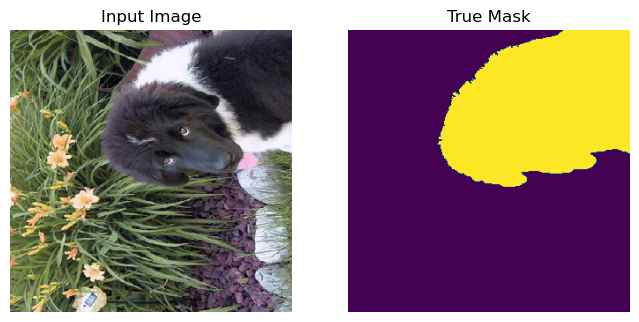

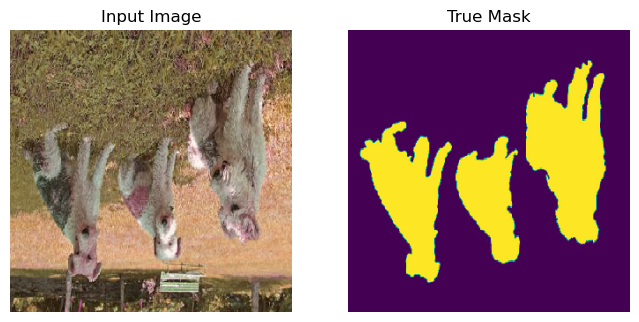

In [15]:
for images, masks in train_dataset.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [6]:
adam = keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=.9, beta_2=.999, epsilon=1e-08)
model = U2NET(shape_image=IMAGE_SHAPE)
model.compile(optimizer=adam, loss=bce_loss)

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
keras.backend.set_session(sess)
print("Session:", tf.config.list_physical_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18059975315842750750
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9392095232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14904921773366058899
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]
Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5

Session: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
checkpoint_path = "training_1/cp.ckpt"

callbacks = [
    keras.callbacks.TensorBoard(log_dir="./logs"),
    keras.callbacks.BackupAndRestore("./bkp"),
]

model.fit(train_dataset, validation_data=test_dataset, callbacks=callbacks, epochs=EPOCHS)
model.save

Layer RSU7 has arguments ['mid_chanels', 'out_chanels']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 31/300
1320/1320 [==============================] - ETA: 0s - loss: 0.2778
Epoch 31: saving model to training_1\cp.ckpt
1320/1320 [==============================] - 883s 639ms/step - loss: 0.2778 - val_loss: 1.8741
Epoch 32/300
1320/1320 [==============================] - ETA: 0s - loss: 0.2299
Epoch 32: saving model to training_1\cp.ckpt
1320/1320 [==============================] - 657s 497ms/step - loss: 0.2299 - val_loss: 1.9380
Epoch 33/300
1320/1320 [==============================] - ETA: 0s - loss: 0.3104
Epoch 33: saving

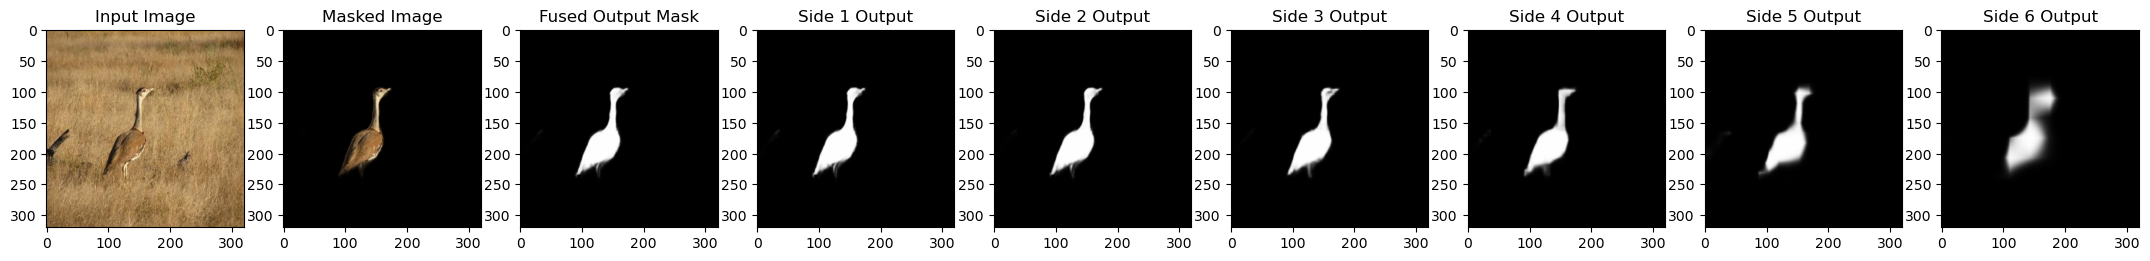

In [29]:
import numpy as np

for image, mask in test_dataset.take(1):
    out = model(image)
    f, a = plt.subplots(1,9,figsize=(27, 3))
    a[0].imshow(image[0])
    a[1].imshow(np.multiply(image[0], np.tile(out[0][0], [1, 1, 3])))
    a[2].imshow(np.tile(out[0][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
    a[3].imshow(np.tile(out[1][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
    a[4].imshow(np.tile(out[2][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
    a[5].imshow(np.tile(out[3][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
    a[6].imshow(np.tile(out[4][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
    a[7].imshow(np.tile(out[5][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)
    a[8].imshow(np.tile(out[6][0], [1, 1, 3]), cmap='gray', vmin=0, vmax=1)

    a[0].set_title('Input Image')
    a[1].set_title('Masked Image')
    a[2].set_title('Fused Output Mask')
    for j, ax in enumerate(a[3:]):
        ax.set_title('Side %d Output' % (j+1))
      
    plt.show()